# HW3

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import scipy.optimize as sco

In [2]:
def get_portf_rtn(w,ave_rtns): 
    return np.sum(ave_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat): 
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [3]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range): 

    efficient_portfolios = []

    n_assets = len(avg_returns) 
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for assets in range(n_assets)) 
    initial_guess = n_assets * [1. / n_assets, ] # length: 4 assets with 0.25 

    for ret in rtns_range: 
        constraints = ({'type': 'eq', 
                       'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, 
                      {'type': 'eq', 
                       'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args = args, method = 'SLSQP', 
                                           constraints = constraints,
                                           bounds = bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios     

In [4]:
N_DAYS = 252 
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [5]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)

[*********************100%***********************]  3 of 3 completed


In [6]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [7]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [8]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [9]:
efficient_portfolios

[     fun: 0.23779113388144266
      jac: array([0.16472408, 0.24562226, 0.18088662])
  message: 'Optimization terminated successfully'
     nfev: 8
      nit: 2
     njev: 2
   status: 0
  success: True
        x: array([9.68022690e-02, 9.03197731e-01, 5.55111512e-17]),
      fun: 0.2367019270686644
      jac: array([0.16830239, 0.24520817, 0.18261874])
  message: 'Optimization terminated successfully'
     nfev: 8
      nit: 2
     njev: 2
   status: 0
  success: True
        x: array([0.11060602, 0.88939398, 0.        ]),
      fun: 0.2356682050915817
      jac: array([0.17187331, 0.24473262, 0.18432347])
  message: 'Optimization terminated successfully'
     nfev: 8
      nit: 2
     njev: 2
   status: 0
  success: True
        x: array([1.24409785e-01, 8.75590215e-01, 5.55111512e-17]),
      fun: 0.234690701259211
      jac: array([0.17543366, 0.24419436, 0.18599866])
  message: 'Optimization terminated successfully'
     nfev: 8
      nit: 2
     njev: 2
   status: 0
  success: T

In [10]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [11]:
min_vol_ind = np.argmin(vols_range) 
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol, 
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': -0.1250251256281407,
 'Volatility': 0.2258047832226755,
 'Sharpe Ratio': -0.5536867901724128}

In [12]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: -12.50% Volatility: 22.58% Sharpe Ratio: -55.37% 
Weights
AAPL: 28.04% IBM: 58.98% MSFT: 12.98% 

In [13]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

In [14]:
n_assets = len(avg_returns) 
RF_RATE = 0 

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)


In [15]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.21458116069327562,
 'Volatility': 0.28353818357815513,
 'Sharpe Ratio': 0.7567981073495449}

In [16]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(RISKY_ASSETS, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 21.46% Volatility: 28.35% Sharpe Ratio: 75.68% 
Weights
AAPL: 0.00% IBM: 0.00% MSFT: 100.00% 

# HW4

In [17]:
efficient_portfolios[min_vol_ind]['x']
max_sharpe_portf_w

array([0.00000000e+00, 3.33066907e-16, 1.00000000e+00])

In [18]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
RISKY_ASSETS.sort()
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [19]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)

[*********************100%***********************]  3 of 3 completed


In [20]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

In [21]:
#포트폴리오 수익률
sharpe_ret = (returns_df * np.array([0.0019, 0.0029, 0.9952])).T.sum()
min_vol_ret = (returns_df * np.array([0.2808, 0.5869, 0.1322])).T.sum()

In [22]:
#포트폴리오 기준가 경로
def cal_path(ret):
    path = [1000]
    for idx, daily_ret in enumerate(ret):
        path.append(path[idx] * (1 + daily_ret))
        
    return path

sharpe_path = cal_path(sharpe_ret)
sharpe_df = pd.DataFrame({
    'prot_ret':sharpe_path
}, index = prices_df.index)

min_vol_ret = cal_path(min_vol_ret)
min_vol_df = pd.DataFrame({
    'port_ret':min_vol_ret
}, index = prices_df.index)

In [23]:
sharpe_train = sharpe_df.pct_change().loc['2018-01-01':'2018-10-31'].dropna()
sharpe_test = sharpe_df.pct_change().loc['2018-11-01':'2018-12-31']

min_vol_train = min_vol_df.pct_change().loc['2018-01-01':'2018-10-31'].dropna()
min_vol_test = min_vol_df.pct_change().loc['2018-11-01':'2018-12-31']

In [24]:
T = len(sharpe_test)
N = len(sharpe_test) 
sharpe_s_0 = sharpe_df.loc[sharpe_train.index[-1]].values[0]
N_SIM = 100 
sharpe_mu = sharpe_train.mean().values[0]
sharpe_sigma = sharpe_train.std().values[0]

min_vol_s_0 = min_vol_df.loc[min_vol_train.index[-1]].values[0]
N_SIM = 100 
min_vol_mu = min_vol_train.mean().values[0]
min_vol_sigma = min_vol_train.std().values[0]

In [25]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [26]:
sharpe_gbm_simulations = simulate_gbm(sharpe_s_0, sharpe_mu, sharpe_sigma, N_SIM, T, N)

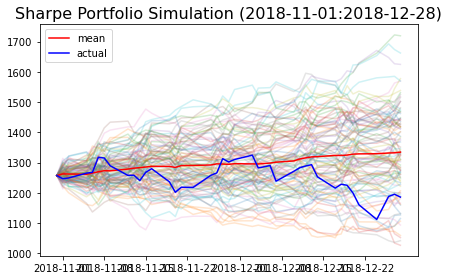

In [27]:

# prepare objects for plotting 
last_train_date = sharpe_train.index[-1].date()
first_test_date = sharpe_test.index[0].date()
last_test_date = sharpe_test.index[-1].date()
plot_title = ('Sharpe Portfolio Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = prices_df[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(sharpe_gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, sharpe_df[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

In [28]:
min_vol_gbm_simulations = simulate_gbm(min_vol_s_0, min_vol_mu, min_vol_sigma, N_SIM, T, N)

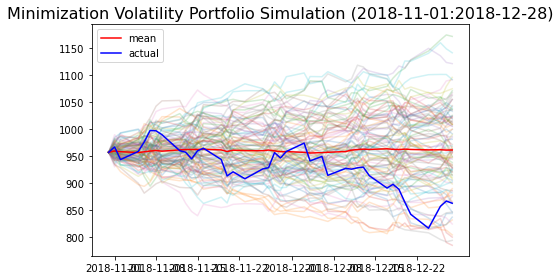

In [29]:

# prepare objects for plotting 
last_train_date = min_vol_train.index[-1].date()
first_test_date = min_vol_test.index[0].date()
last_test_date = min_vol_test.index[-1].date()
plot_title = ('Minimization Volatility Portfolio Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = prices_df[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(min_vol_gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, min_vol_df[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()